In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as torchvision_transforms
import numpy as np
import os
import pandas as pd
import math
import ntpath

from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange

import warnings
warnings.filterwarnings("ignore")

# from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
from myhelpers import config_plots
from HGNN.train import CNN, dataLoader

# config_plots.global_settings()

experimetnsFileName = "experiments.csv"

In [2]:
# Model parameters
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish"
experimentName="Fish30-5run-PhyloNN6" #"Fish50_30-5run-BB-HGNN-crossvalidation" 
trial_hash="0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4" #PhyloNN
#"9d6646b1d44b3034255f21a9d658fffe2f80e4f2180745e169abeb72" #HGNN

# image file:
# fileName= '/raid/elhamod/Fish/Curated4/Easy_50/test/Notropis nubilus/INHS_FISH_81913.jpg'
fileName= '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg'

# MISC
cuda=1
SEED_INT=-1

In [3]:
project="Fish_activationMaximization_GAP400_hyperp2"

sweep_config = {
    'method': 'bayes',
    'early_terminate': {
       'type': 'hyperband',
       'min_iter': 8   
    }
}
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }
sweep_config['metric'] = metric

COUNT=1000


params = {
    "useRegularization":{'values': [True, False]},
    "useRandomInitImage":{'values': [True, False]},
    "L1_reg":{'values': [True, False]},
    "iterations":{
        'distribution': 'q_uniform',
        'min': 10,
        'max': 10000,
        'q':10
    },
    "weight_decay":{
        'distribution': 'log_uniform',
        'min': math.log(0.00001),
        'max': math.log(10),
    },
    "learning_rate":{
        'distribution': 'log_uniform',
        'min': math.log(0.00001),
        'max': math.log(10),
    },
}

GAPfeatureGenerate=True
layerName_GAP='gap_features'
GAP_output_index = slice(400, 401)

sweep_config['parameters'] = params

In [4]:
# set cuda
if cuda is not None:
    print("using cuda", cuda)
    torch.cuda.set_device(cuda)

using cuda 1


In [5]:
# Get experiment parameters
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
modelName = experimentRecord.iloc[0]["modelName"]
experimentPathAndName = os.path.join(experimentsPath, experimentName)
trialName = os.path.join(experimentPathAndName, modelName)
experiment_params = experimentRecord.to_dict('records')[0]
experiment_params = config_parser.fixExperimentParams(experiment_params)

if math.isnan(experiment_params['suffix']):
    experiment_params['suffix'] = None
print(experiment_params)

{'experimentName': 'Fish30-5run-PhyloNN6', 'modelName': 'models/0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'datasetName': 'datasplits/a30fade0855f8d4a9e28fdac4e65ae71ab21444a323ee6e3927d97f8', 'experimentHash': '2f4afd9af84811c61585f52e9e69fb2b8fc8e83ae71fa846e602b672', 'trialHash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'image_path': 'Curated4/Easy_30', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.001, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'PhyloNN', 'lambda': 1.0, 'unsupervisedOnTest': nan, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': False, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'noSpeciesBackprop': False, 'phylogeny_loss': 'False', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': False, 'tripletSamples': 2.0, 'tripletSelector': 'semihard', 'tripletMargin': 2.0, 'displayName': 'Fish30-5run-PhyloNN-smalldistances-intraKorthogonality', 'pretrained': True, 'epochs'

In [6]:
experimentPathAndName = os.path.join(experimentsPath, experimentName)
datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

In [7]:
datasetManager.updateParams(config_parser.fixPaths(experiment_params))

In [8]:
%%capture
train_loader, validation_loader, test_loader = datasetManager.getLoaders(SEED_INT)
# architecture = {
#     "fine": len(train_loader.dataset.csv_processor.getFineList()),
#     "coarse" : len(train_loader.dataset.csv_processor.getCoarseList())
# }
architecture = CNN.get_architecture(experiment_params, train_loader.dataset.csv_processor)
model = CNN.create_model(architecture, experiment_params, device=cuda)
CNN.loadModel(model, trialName, device=cuda)

In [9]:
def getTransformedImage(dataset, img, augmentation, normalization):
    augmentation2, normalization2, pad2 = dataset.toggle_image_loading(augmentation=augmentation, normalization=normalization)
    transforms = dataset.getTransforms()
    composedTransforms = torchvision_transforms.Compose(transforms)
    img_clone = composedTransforms(img)
#     print(img_clone.shape)
#     img_clone = img_clone.unsqueeze(0)
#     print(img_clone.shape)
    dataset.toggle_image_loading(augmentation2, normalization2, pad2)
    return img_clone

(-0.5, 447.5, 447.5, -0.5)

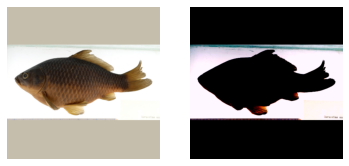

In [10]:
fig, axarr = plt.subplots(1, 2)


title = ntpath.basename(fileName)
original =  Image.open(fileName)
image_non_normalized = getTransformedImage(test_loader.dataset, original, False, False)
image_normalized = getTransformedImage(test_loader.dataset, original, False, True)

axarr[0].imshow(np.transpose(image_non_normalized.detach().numpy(), (1, 2, 0)))
axarr[1].imshow(np.transpose(image_normalized.detach().numpy(), (1, 2, 0)))
axarr[0].axis('off')
axarr[1].axis('off')

In [11]:
model.eval()
img = image_normalized.unsqueeze(0)
if cuda is not None:
    img = img.cuda()
output = model(img)
output_class = torch.argmax(output['fine'].squeeze())
im = transforms.ToPILImage()(image_non_normalized).convert("RGB")

In [12]:
import wandb

wandb.login()

wandb: Currently logged in as: mndhamod (use `wandb login --relogin` to force relogin)


True

In [13]:
from pytorchVisualizations.generate_class_specific_samples import ClassSpecificImageGeneration
from pytorchVisualizations.generate_regularized_class_specific_samples import RegularizedClassSpecificImageGeneration
from PIL import Image
import matplotlib.pyplot as plt

def train(config=None):
    run = wandb.init()

    experiment_params=wandb.config if config is None else config
    experiment_params = dict(experiment_params)
    row_information = {
        "experimentsPath":experimentsPath,
        "dataPath":dataPath,
        "experimentName":experimentName,
        "trial_hash":trial_hash,
        "fileName": fileName
    }
    row_information = {**row_information, **experiment_params} 
    print(row_information)

    useRandomInitImage = experiment_params["useRandomInitImage"]
    iterations = experiment_params["iterations"]
    learning_rate = experiment_params["learning_rate"]
    weight_decay = experiment_params["weight_decay"]
    L1_reg = experiment_params["L1_reg"]
    useRegularization = experiment_params["useRegularization"]
    img = image_non_normalized.unsqueeze(0) if not useRandomInitImage else None
    if not GAPfeatureGenerate:
        if not useRegularization:
            csig = ClassSpecificImageGeneration(model, output_class.item(), img, cuda=cuda, normalizer=test_loader.dataset.normalizer)
            im_generated, loss  = csig.generate(iterations=iterations, initial_learning_rate=learning_rate)
        else:
            csig = RegularizedClassSpecificImageGeneration(model, output_class.item(), img, cuda=cuda, normalizer=test_loader.dataset.normalizer)
            im_generated, loss = csig.generate(iterations=iterations, initial_learning_rate=learning_rate, wd=weight_decay, L1_reg=L1_reg)
    else:
        if not useRegularization:
            csig = ClassSpecificImageGeneration(model, GAP_output_index, img, cuda=cuda, layer_name=layerName_GAP, normalizer=test_loader.dataset.normalizer)
            im_generated, loss  = csig.generate(iterations=iterations, initial_learning_rate=learning_rate)
        else:
            csig = RegularizedClassSpecificImageGeneration(model, GAP_output_index, img, cuda=cuda, layer_name=layerName_GAP, normalizer=test_loader.dataset.normalizer)
            im_generated, loss = csig.generate(iterations=iterations, initial_learning_rate=learning_rate, wd=weight_decay, L1_reg=L1_reg)
    
    plt_img = im_generated.squeeze().permute(1,2,0).detach().numpy()
    plt_img = (plt_img*255).astype(np.uint8)
    plt_img = Image.fromarray(plt_img)
    if not GAPfeatureGenerate:
        dist = torch.nn.Softmax()(model(im_generated_normalized.unsqueeze(0))['fine'])[0].tolist()
    else:
        dist = model.activations(im_generated.unsqueeze(0))[layerName_GAP][0].tolist()
    dist = list(map(lambda x: [x[0], x[1]], enumerate(dist)))
    dist = wandb.Table(data=dist, columns=["class", "probability"])
    wandb.log({"loss": loss, "distribution": wandb.plot.bar(dist, 'class', 'probability'), "output": wandb.Image(plt_img)})
    
    run.finish()

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=project)
wandb.agent(sweep_id, function=train, count=COUNT)

Create sweep with ID: j36n1vj5
Sweep URL: https://wandb.ai/mndhamod/Fish_activationMaximization_GAP400_hyperp2/sweeps/j36n1vj5


wandb: Agent Starting Run: nfvrxw66 with config:
wandb: 	L1_reg: True
wandb: 	iterations: 590
wandb: 	learning_rate: 3.269373661339895e-05
wandb: 	useRandomInitImage: True
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.0031543299093776942
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': True, 'iterations': 590, 'learning_rate': 3.269373661339895e-05, 'useRandomInitImage': True, 'useRegularization': False, 'weight_decay': 0.0031543299093776942}
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<Sli

wandb: Agent Starting Run: 400664sq with config:
wandb: 	L1_reg: True
wandb: 	iterations: 2280
wandb: 	learning_rate: 0.002247172077530712
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: True
wandb: 	weight_decay: 0.0009121864539437596
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': True, 'iterations': 2280, 'learning_rate': 0.002247172077530712, 'useRandomInitImage': False, 'useRegularization': True, 'weight_decay': 0.0009121864539437596}


wandb: Agent Starting Run: 4ubgt8c0 with config:
wandb: 	L1_reg: False
wandb: 	iterations: 2850
wandb: 	learning_rate: 0.055392694715818425
wandb: 	useRandomInitImage: True
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.014627360893538242
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 2850, 'learning_rate': 0.055392694715818425, 'useRandomInitImage': True, 'useRegularization': False, 'weight_decay': 0.014627360893538242}
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004], grad_fn=<SliceBackward0>)
tensor([0.0004],

wandb: Agent Starting Run: hko6fo4c with config:
wandb: 	L1_reg: False
wandb: 	iterations: 7350
wandb: 	learning_rate: 0.0003061419421933208
wandb: 	useRandomInitImage: True
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.014097404734800468
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 7350, 'learning_rate': 0.0003061419421933208, 'useRandomInitImage': True, 'useRegularization': False, 'weight_decay': 0.014097404734800468}
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<SliceBackward0>)
tensor([0.], grad_fn=<Sl

wandb: Agent Starting Run: 0fehbk2t with config:
wandb: 	L1_reg: True
wandb: 	iterations: 1500
wandb: 	learning_rate: 0.06539916213143088
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: True
wandb: 	weight_decay: 0.0016295296913813036
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': True, 'iterations': 1500, 'learning_rate': 0.06539916213143088, 'useRandomInitImage': False, 'useRegularization': True, 'weight_decay': 0.0016295296913813036}


wandb: Agent Starting Run: ppoyjo34 with config:
wandb: 	L1_reg: False
wandb: 	iterations: 2410
wandb: 	learning_rate: 0.01708048744602454
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.0002932378386491696
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 2410, 'learning_rate': 0.01708048744602454, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 0.0002932378386491696}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([0.7983], grad_fn=<SliceBackward0>)
tensor([0.8167], grad_fn=<SliceBackward0>)
tensor([0.8392], grad_fn=<SliceBackward0>)
tensor([0.8622], grad_fn=<SliceBackward0>)
tensor([0.8847], grad_fn=<SliceBackward0>)
tensor([0.9077], grad_fn=<SliceBackward0>)
tensor([0.9307], grad_fn=<SliceBackward0>)
tensor([0.9543], grad_fn=<SliceBackward0>)
tensor([0.9773], grad_fn=<SliceBackward0>)
tensor([1.0007], grad_fn=<SliceBackward0>)
tensor([1.0249], grad_fn=<SliceBackward0>)
tensor([1.0500]

wandb: Agent Starting Run: fiab29pe with config:
wandb: 	L1_reg: False
wandb: 	iterations: 4530
wandb: 	learning_rate: 1.851237937728052e-05
wandb: 	useRandomInitImage: True
wandb: 	useRegularization: True
wandb: 	weight_decay: 0.0036621754651373567
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 4530, 'learning_rate': 1.851237937728052e-05, 'useRandomInitImage': True, 'useRegularization': True, 'weight_decay': 0.0036621754651373567}


wandb: Agent Starting Run: d1sguonx with config:
wandb: 	L1_reg: True
wandb: 	iterations: 5760
wandb: 	learning_rate: 0.0010090381471315186
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: True
wandb: 	weight_decay: 0.0007288177358588435
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': True, 'iterations': 5760, 'learning_rate': 0.0010090381471315186, 'useRandomInitImage': False, 'useRegularization': True, 'weight_decay': 0.0007288177358588435}


wandb: Agent Starting Run: eyrcs92w with config:
wandb: 	L1_reg: False
wandb: 	iterations: 1200
wandb: 	learning_rate: 0.606039891383111
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 6.223405751139624
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 1200, 'learning_rate': 0.606039891383111, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 6.223405751139624}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([1.1953], grad_fn=<SliceBackward0>)
tensor([1.6721], grad_fn=<SliceBackward0>)
tensor([2.2421], grad_fn=<SliceBackward0>)
tensor([2.6934], grad_fn=<SliceBackward0>)
tensor([3.1377], grad_fn=<SliceBackward0>)
tensor([3.6375], grad_fn=<SliceBackward0>)
tensor([4.1526], grad_fn=<SliceBackward0>)
tensor([4.5173], grad_fn=<SliceBackward0>)
tensor([4.9610], grad_fn=<SliceBackward0>)
tensor([5.8001], grad_fn=<SliceBackward0>)
tensor([6.2504], grad_fn=<SliceBackward0>)
tensor([6.7093], grad

wandb: Agent Starting Run: aexl5i6w with config:
wandb: 	L1_reg: False
wandb: 	iterations: 5620
wandb: 	learning_rate: 0.3666473686049014
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.9783503217389268
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 5620, 'learning_rate': 0.3666473686049014, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 0.9783503217389268}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([1.0655], grad_fn=<SliceBackward0>)
tensor([1.4128], grad_fn=<SliceBackward0>)
tensor([1.7979], grad_fn=<SliceBackward0>)
tensor([2.2058], grad_fn=<SliceBackward0>)
tensor([2.6520], grad_fn=<SliceBackward0>)
tensor([3.0915], grad_fn=<SliceBackward0>)
tensor([3.4952], grad_fn=<SliceBackward0>)
tensor([3.8821], grad_fn=<SliceBackward0>)
tensor([4.3288], grad_fn=<SliceBackward0>)
tensor([4.7104], grad_fn=<SliceBackward0>)
tensor([4.9345], grad_fn=<SliceBackward0>)
tensor([5.4303], gr

wandb: Agent Starting Run: bcz414ez with config:
wandb: 	L1_reg: False
wandb: 	iterations: 7990
wandb: 	learning_rate: 3.127681696079849
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 3.1568038524021405
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 7990, 'learning_rate': 3.127681696079849, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 3.1568038524021405}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([1.8326], grad_fn=<SliceBackward0>)
tensor([2.6054], grad_fn=<SliceBackward0>)
tensor([3.2384], grad_fn=<SliceBackward0>)
tensor([4.1702], grad_fn=<SliceBackward0>)
tensor([4.9290], grad_fn=<SliceBackward0>)
tensor([5.9720], grad_fn=<SliceBackward0>)
tensor([7.1523], grad_fn=<SliceBackward0>)
tensor([7.6341], grad_fn=<SliceBackward0>)
tensor([8.4343], grad_fn=<SliceBackward0>)
tensor([9.5911], grad_fn=<SliceBackward0>)
tensor([10.0855], grad_fn=<SliceBackward0>)
tensor([11.1695], g

wandb: Agent Starting Run: 2rzbeio3 with config:
wandb: 	L1_reg: False
wandb: 	iterations: 8630
wandb: 	learning_rate: 0.9887259548269838
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 1.5722514872112128
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 8630, 'learning_rate': 0.9887259548269838, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 1.5722514872112128}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([1.3569], grad_fn=<SliceBackward0>)
tensor([2.0556], grad_fn=<SliceBackward0>)
tensor([2.7420], grad_fn=<SliceBackward0>)
tensor([3.2618], grad_fn=<SliceBackward0>)
tensor([3.9026], grad_fn=<SliceBackward0>)
tensor([4.4738], grad_fn=<SliceBackward0>)
tensor([5.1168], grad_fn=<SliceBackward0>)
tensor([5.8107], grad_fn=<SliceBackward0>)
tensor([6.5895], grad_fn=<SliceBackward0>)
tensor([7.6229], grad_fn=<SliceBackward0>)
tensor([8.0766], grad_fn=<SliceBackward0>)
tensor([8.9728], gr

wandb: Agent Starting Run: r5f3jelo with config:
wandb: 	L1_reg: False
wandb: 	iterations: 7070
wandb: 	learning_rate: 1.047061216081167
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 2.8174741317653687
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 7070, 'learning_rate': 1.047061216081167, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 2.8174741317653687}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([1.3784], grad_fn=<SliceBackward0>)
tensor([2.0927], grad_fn=<SliceBackward0>)
tensor([2.7594], grad_fn=<SliceBackward0>)
tensor([3.3113], grad_fn=<SliceBackward0>)
tensor([3.9165], grad_fn=<SliceBackward0>)
tensor([4.6810], grad_fn=<SliceBackward0>)
tensor([5.1356], grad_fn=<SliceBackward0>)
tensor([5.9703], grad_fn=<SliceBackward0>)
tensor([7.1111], grad_fn=<SliceBackward0>)
tensor([7.9707], grad_fn=<SliceBackward0>)
tensor([8.4307], grad_fn=<SliceBackward0>)
tensor([9.1822], gra

wandb: Agent Starting Run: 7a4kej3u with config:
wandb: 	L1_reg: False
wandb: 	iterations: 8840
wandb: 	learning_rate: 8.822840317270783
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 4.612570872866788
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 8840, 'learning_rate': 8.822840317270783, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 4.612570872866788}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([2.0793], grad_fn=<SliceBackward0>)
tensor([2.4959], grad_fn=<SliceBackward0>)
tensor([3.6638], grad_fn=<SliceBackward0>)
tensor([4.6428], grad_fn=<SliceBackward0>)
tensor([6.1883], grad_fn=<SliceBackward0>)
tensor([7.0137], grad_fn=<SliceBackward0>)
tensor([6.2975], grad_fn=<SliceBackward0>)
tensor([8.4131], grad_fn=<SliceBackward0>)
tensor([8.5446], grad_fn=<SliceBackward0>)
tensor([10.3769], grad_fn=<SliceBackward0>)
tensor([11.8356], grad_fn=<SliceBackward0>)
tensor([12.8461], g

wandb: Agent Starting Run: r0ibvvmk with config:
wandb: 	L1_reg: False
wandb: 	iterations: 7020
wandb: 	learning_rate: 9.779266401375851
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.0857964774021112
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 7020, 'learning_rate': 9.779266401375851, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 0.0857964774021112}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([2.0780], grad_fn=<SliceBackward0>)
tensor([2.5431], grad_fn=<SliceBackward0>)
tensor([3.5541], grad_fn=<SliceBackward0>)
tensor([5.2270], grad_fn=<SliceBackward0>)
tensor([6.1048], grad_fn=<SliceBackward0>)
tensor([6.6175], grad_fn=<SliceBackward0>)
tensor([7.5525], grad_fn=<SliceBackward0>)
tensor([8.6423], grad_fn=<SliceBackward0>)
tensor([8.9713], grad_fn=<SliceBackward0>)
tensor([10.1444], grad_fn=<SliceBackward0>)
tensor([11.5301], grad_fn=<SliceBackward0>)
tensor([12.6109], 

wandb: Agent Starting Run: ayvjq7cs with config:
wandb: 	L1_reg: False
wandb: 	iterations: 6240
wandb: 	learning_rate: 7.033622057391152
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.39681102909070953
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 6240, 'learning_rate': 7.033622057391152, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 0.39681102909070953}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([2.0684], grad_fn=<SliceBackward0>)
tensor([2.6172], grad_fn=<SliceBackward0>)
tensor([3.7024], grad_fn=<SliceBackward0>)
tensor([4.8457], grad_fn=<SliceBackward0>)
tensor([5.8650], grad_fn=<SliceBackward0>)
tensor([6.8903], grad_fn=<SliceBackward0>)
tensor([7.2273], grad_fn=<SliceBackward0>)
tensor([8.5952], grad_fn=<SliceBackward0>)
tensor([8.9295], grad_fn=<SliceBackward0>)
tensor([10.1379], grad_fn=<SliceBackward0>)
tensor([11.0420], grad_fn=<SliceBackward0>)
tensor([11.9108],

wandb: Agent Starting Run: pzf0l4ts with config:
wandb: 	L1_reg: False
wandb: 	iterations: 7110
wandb: 	learning_rate: 5.225126166218264
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.04385698497001459
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 7110, 'learning_rate': 5.225126166218264, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 0.04385698497001459}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([2.0094], grad_fn=<SliceBackward0>)
tensor([2.6587], grad_fn=<SliceBackward0>)
tensor([3.7080], grad_fn=<SliceBackward0>)
tensor([4.7686], grad_fn=<SliceBackward0>)
tensor([5.8684], grad_fn=<SliceBackward0>)
tensor([6.9898], grad_fn=<SliceBackward0>)
tensor([7.3633], grad_fn=<SliceBackward0>)
tensor([8.3731], grad_fn=<SliceBackward0>)
tensor([9.4862], grad_fn=<SliceBackward0>)
tensor([10.6952], grad_fn=<SliceBackward0>)
tensor([11.7123], grad_fn=<SliceBackward0>)
tensor([13.0364],

wandb: Agent Starting Run: 633j1g6c with config:
wandb: 	L1_reg: False
wandb: 	iterations: 6580
wandb: 	learning_rate: 9.55436929877474
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.6806207150152339
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': False, 'iterations': 6580, 'learning_rate': 9.55436929877474, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 0.6806207150152339}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([2.0786], grad_fn=<SliceBackward0>)
tensor([2.5742], grad_fn=<SliceBackward0>)
tensor([3.6363], grad_fn=<SliceBackward0>)
tensor([5.0688], grad_fn=<SliceBackward0>)
tensor([5.8454], grad_fn=<SliceBackward0>)
tensor([7.0017], grad_fn=<SliceBackward0>)
tensor([7.8741], grad_fn=<SliceBackward0>)
tensor([8.5007], grad_fn=<SliceBackward0>)
tensor([9.1908], grad_fn=<SliceBackward0>)
tensor([10.2390], grad_fn=<SliceBackward0>)
tensor([10.4855], grad_fn=<SliceBackward0>)
tensor([12.4519], g

wandb: Agent Starting Run: m0q60c0w with config:
wandb: 	L1_reg: True
wandb: 	iterations: 9760
wandb: 	learning_rate: 9.67797656997899
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: True
wandb: 	weight_decay: 0.3725753636736419
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': True, 'iterations': 9760, 'learning_rate': 9.67797656997899, 'useRandomInitImage': False, 'useRegularization': True, 'weight_decay': 0.3725753636736419}


wandb: Agent Starting Run: 2mjrcgkp with config:
wandb: 	L1_reg: True
wandb: 	iterations: 9880
wandb: 	learning_rate: 9.732041365510176
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 0.31356885843622956
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': True, 'iterations': 9880, 'learning_rate': 9.732041365510176, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 0.31356885843622956}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([2.0781], grad_fn=<SliceBackward0>)
tensor([2.5383], grad_fn=<SliceBackward0>)
tensor([3.6198], grad_fn=<SliceBackward0>)
tensor([5.0604], grad_fn=<SliceBackward0>)
tensor([6.1350], grad_fn=<SliceBackward0>)
tensor([6.5992], grad_fn=<SliceBackward0>)
tensor([7.5208], grad_fn=<SliceBackward0>)
tensor([8.3002], grad_fn=<SliceBackward0>)
tensor([9.1516], grad_fn=<SliceBackward0>)
tensor([10.1947], grad_fn=<SliceBackward0>)
tensor([11.1405], grad_fn=<SliceBackward0>)
tensor([11.7753], 

wandb: Agent Starting Run: s8k4kd3h with config:
wandb: 	L1_reg: True
wandb: 	iterations: 9500
wandb: 	learning_rate: 0.9427236703127188
wandb: 	useRandomInitImage: False
wandb: 	useRegularization: False
wandb: 	weight_decay: 2.3814301281131476
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'experimentsPath': '/raid/elhamod/Fish/experiments/', 'dataPath': '/raid/elhamod/Fish', 'experimentName': 'Fish30-5run-PhyloNN6', 'trial_hash': '0e8bc6eb6edfb88c5a419e14ab0b445d72ee1945bd474a26a7abcbd4', 'fileName': '/raid/elhamod/Fish/Curated4/Easy_30/test/Carassius auratus/INHS_FISH_4916.jpg', 'L1_reg': True, 'iterations': 9500, 'learning_rate': 0.9427236703127188, 'useRandomInitImage': False, 'useRegularization': False, 'weight_decay': 2.3814301281131476}
tensor([0.7823], grad_fn=<SliceBackward0>)
tensor([1.3393], grad_fn=<SliceBackward0>)
tensor([2.0084], grad_fn=<SliceBackward0>)
tensor([2.6718], grad_fn=<SliceBackward0>)
tensor([3.2142], grad_fn=<SliceBackward0>)
tensor([3.7885], grad_fn=<SliceBackward0>)
tensor([4.4724], grad_fn=<SliceBackward0>)
tensor([5.0827], grad_fn=<SliceBackward0>)
tensor([6.1581], grad_fn=<SliceBackward0>)
tensor([6.4369], grad_fn=<SliceBackward0>)
tensor([7.4589], grad_fn=<SliceBackward0>)
tensor([8.2545], grad_fn=<SliceBackward0>)
tensor([8.8003], gra

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/elhamod/melhamodenv3/lib/python3.6/site-packages/wandb/sdk/internal/internal_api.py", line 1233, in agent_heartbeat
    timeout=60,
  File "/home/elhamod/melhamodenv3/lib/python3.6/site-packages/wandb/old/retry.py", line 100, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/home/elhamod/melhamodenv3/lib/python3.6/site-packages/wandb/sdk/internal/internal_api.py", line 127, in execute
    return self.client.execute(*args, **kwargs)
  File "/home/elhamod/melhamodenv3/lib/python3.6/site-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 52, in execute
    result = self._get_result(document, *args, **kwargs)
  File "/home/elhamod/melhamodenv3/lib/python3.6/site-packages/wandb/vendor/gql-0.2.0/gql/client.py", line 60, in _get_result
    return self.transport.execute(document, *args, **kwargs)
  File "/home/elhamod/melhamodenv3/lib/python3.6/site-packages/wandb/vendor/gql-0.2.0/gql/transport/requ